# DATA_CURATOR TEST

## **PART 1: Merging the three files and generating h5ad format file for the cells having metadata**

In [1]:
# reading in given files
import scanpy as sc
import anndata as ann
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


sc._settings.ScanpyConfig(file_format_data='h5ad', autosave=True, file_format_figs='png' ,figdir="/Users/mansichaudhari/Desktop/Data_Curator_Test/")

#Loading the three files
gene_matrix = sc.read("/Users/kp/Desktop/Data_Curator_Test/GeneExpression.txt.gz", cache_compression='gzip')
metadata= pd.read_csv("/Users/kp/Desktop/Data_Curator_Test/MetaData.csv", dtype=str)
sample_info = pd.read_excel ("/Users/kp/Desktop/Data_Curator_Test/SampleInfo.xlsx", dtype=str)

In [2]:
#Data cleaning and merging the metadata and sample info


#to make sure the data is uniform : changing all values of age to be just numbers and for sex - only M or F should be there

sample_info.age = sample_info.age.replace(r'[^0-9]', '', regex=True)
sample_info.loc[sample_info.sex == 'male', 'sex'] = 'M'

#merging the metadata and sample infor based on 'donor' column

merged_metadata = metadata.merge(sample_info, left_on=metadata.Donor, right_on=sample_info.donor, how='left')

#cleaning the merged dataframe and extracting the cellnames having metadata

merged_metadata = merged_metadata.drop(columns=['key_0', 'donor'])
merged_metadata = merged_metadata.rename(columns={'Unnamed: 0': 'Cells'})
#merged_metadata.isnull().sum().sum()
cells_with_metadata = merged_metadata.Cells.tolist()

In [3]:
#creating AnnData object from the gene matrix file

def get_subset_matrix(matrix, cells_to_keep, metadata):
    gene_matrix = ann.AnnData(matrix)
    gene_matrix = gene_matrix.copy().T
    #Subsetting the Anndata object to keep only the cells having metadata
    subset_gene_matrix = gene_matrix[gene_matrix.obs_names.isin(cells_with_metadata)]
    #adding metadata info to the anndata object 
    subset_gene_matrix.obs = metadata.set_index('Cells').loc[subset_gene_matrix.obs_names]
    return subset_gene_matrix
    

subset_gene_matrix = get_subset_matrix(gene_matrix, cells_with_metadata, merged_metadata)
#gene_matrix = gene_matrix[gene_matrix.obs.index.isin(merged_metadata.index)] - to check if any NAs present
subset_gene_matrix.write_h5ad(filename="/Users/kp/Desktop/Data_Curator_Test/combined_cells_with_metadata.h5ad")

## Part 2: Generating UMAP embedding for the subsetted matrix having only the cells with metadata

In [4]:
#Inspecting the subset_gene_matrix

subset_gene_matrix.var
subset_gene_matrix.obs

,Cluster,Donor,age,sex
ASGR1_CD45_UNB_P4_5_16,1,325,77,F
ASGR1_CD45_UNB_P4_5_19,1,325,77,F
ASGR1_CD45_UNB_P4_5_26,2,325,77,F
ASGR1_CD45_UNB_P4_5_27,3,325,77,F
ASGR1_CD45_UNB_P4_5_30,4,325,77,F
...,...,...,...,...
Trop2pos315_3_82,7,315,69,M
Trop2pos315_3_83,4,315,69,M
Trop2pos315_3_89,17,315,69,M
Trop2pos315_3_92,4,315,69,M


### Preprocessing

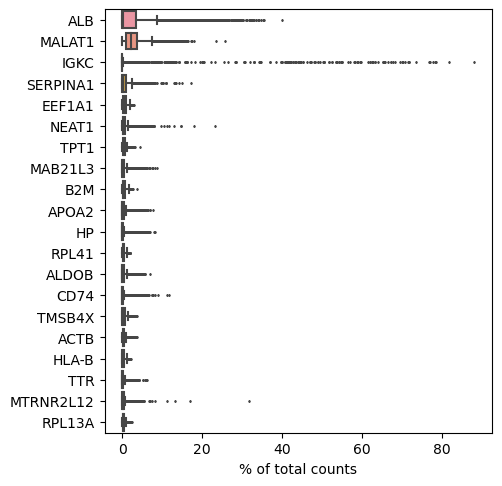

In [5]:
#checking genes that yield the highest fraction of counts in each single cell, across all cells.

sc.pl.highest_expr_genes(subset_gene_matrix, n_top=20)

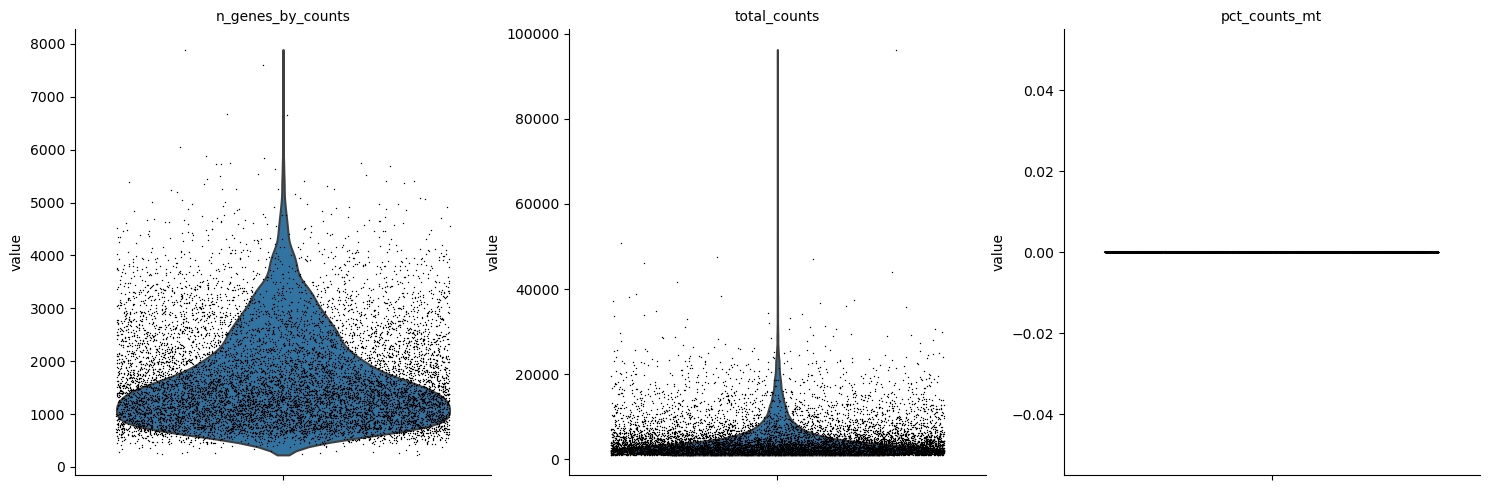

In [6]:
#Cell Quality control (QC)
sc.pp.filter_cells(subset_gene_matrix, min_genes=200)
sc.pp.filter_genes(subset_gene_matrix, min_cells=3)

# identifying mitochondrial genes starting with 'mt'
subset_gene_matrix.var['mt'] = subset_gene_matrix.var_names.str.startswith('MT-') 

#Calculating QC_metrics
sc.pp.calculate_qc_metrics(subset_gene_matrix, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Plotting QC metrics- number of genes expressed in the count matrix, total counts per cell, percentage of counts in mitochondrial genes

sc.pl.violin(subset_gene_matrix, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [7]:
#Filtering
subset_gene_matrix = subset_gene_matrix[subset_gene_matrix.obs.n_genes_by_counts < 2500, :]
subset_gene_matrix = subset_gene_matrix[subset_gene_matrix.obs.pct_counts_mt < 5, :]

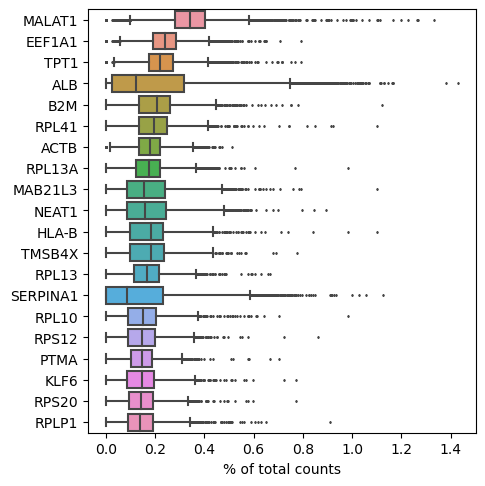

In [8]:
# Normalising the data
sc.pp.normalize_total(subset_gene_matrix) 

#Log-transforming the data
sc.pp.log1p(subset_gene_matrix)  

sc.pl.highest_expr_genes(subset_gene_matrix, n_top=20)

### PCA Analysis

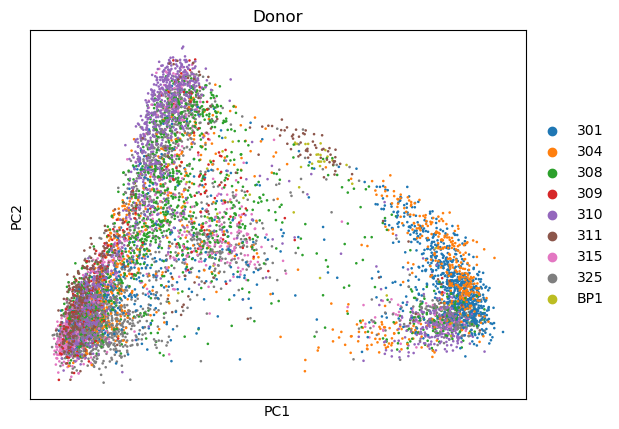

In [9]:
#Dimentionality reduction using PCA

sc.tl.pca(subset_gene_matrix, svd_solver='arpack')
sc.pl.pca(subset_gene_matrix, color='Donor')

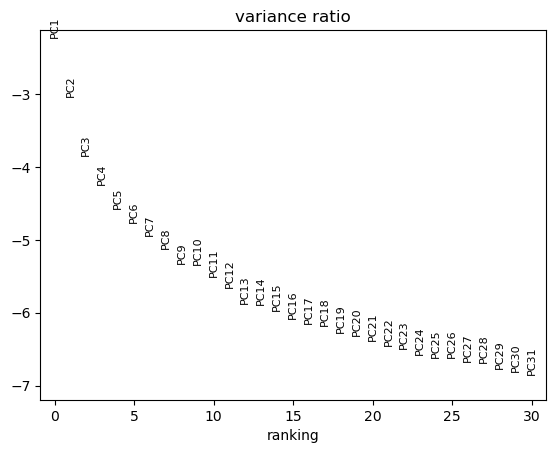

In [10]:
#To get info about how many PCs should be considered in order to compute the neighborhood relations of cells

sc.pl.pca_variance_ratio(subset_gene_matrix, log=True)

In [11]:
#Computing neighborhood graph

sc.pp.neighbors(subset_gene_matrix, n_neighbors=10, n_pcs=30)

### UMAP Embedding

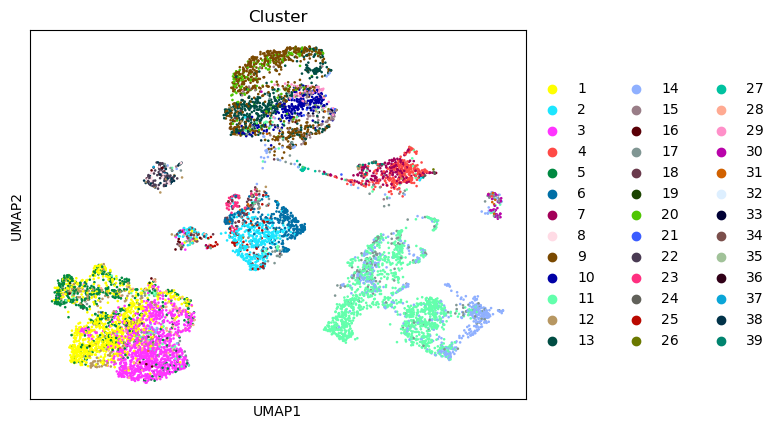

In [17]:
#Embedding the graph in two dimensions using UMAP
sc.tl.umap(subset_gene_matrix)

sc.pl.umap(subset_gene_matrix, color='Cluster', save=True)

In [20]:
umap_coord = subset_gene_matrix.obsm["X_umap"] 
subset_gene_matrix.write_h5ad(filename="/Users/kp/Desktop/Data_Curator_Test/UMAP_embedding.h5ad")

print(subset_gene_matrix)

AnnData object with n_obs × n_vars = 8527 × 23013
    obs: 'Cluster', 'Donor', 'age', 'sex', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca', 'Donor_colors', 'neighbors', 'umap', 'Cluster_colors', 'sex_colors', 'age_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


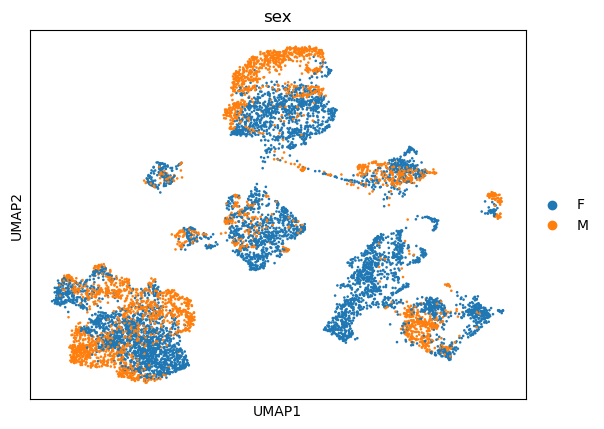

In [13]:
sc.pl.umap(subset_gene_matrix, color='sex', save=True)

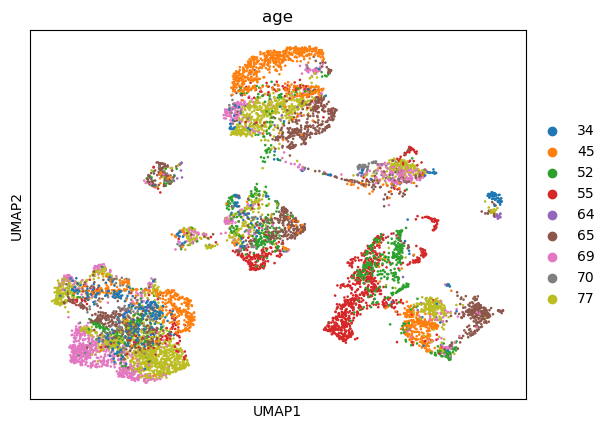

In [14]:
sc.pl.umap(subset_gene_matrix, color='age', save=True, fig_)
#sc.tl.rank_genes_groups(subset_gene_matrix, groupby='Cluster', method='t-test', n_genes=10, min_in_group=1)